# Data assimilation and deep learning applied to a shallow water model: advanced questions

##### Sibo Cheng, CEREA, ENPC, [sibo.cheng@enpc.fr](mailto:sibo.cheng@enpc.fr)

In this notebook, you will train a deep learning surrogate model for the shallow water system and perform variational data assimilation using neural networks for parameter calibration.

This notebook is NOT MONDATORY for the evaluation!

# I. A deep learning surrogate model

Physics simulations can be time-consuming; training a surrogate (meta-)model to learn from data generated by a physics-based code is widely used to accelerate predictions. 

You will be asked to train a surrogate model of the shallow water system with initial conditions Q (inflow), g (gravity coefficient),h (initial water level) as input, with the full h and u fields at time step 100 as outputs   

# II. Data assimilation for parameter calibration

You fully observe the h and u fields at at time step 100 and you would like to identify the initial conditions Q,g,h with the help of the surrogate model in I. You can use the average value of these parameters as an initial guess.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from shallow_water_model import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

cpu


In [3]:
Nx = 100
dx = 1.0
dt = 0.03
Nt_target = 100  # we want h and u at time index 100

def simulate_shallow_water(Q, g, h_anom):
    """
    Run the shallow water model for Nt_target steps with given (Q, g, h_anom)
    and return h(x, t=Nt_target), u(x, t=Nt_target).
    """
    model = ShallowWaterModel(Nx=Nx, dx=dx, dt=dt, Q=Q, g=g)
    state = model.new_state_crenel(h_anom=h_anom)

    for _ in range(Nt_target):
        model.forward(state)

    # Copy to avoid side-effects
    h_final = state.h.copy()
    u_final = state.u.copy()
    return h_final, u_final


In [4]:
# Define the range of different parameters
Q_min, Q_max = 0.05, 0.20
g_min, g_max = 9.5, 10.5
h_min, h_max = 1.02, 1.15

def sample_parameters(batch_size=1):

    Q = np.random.uniform(Q_min, Q_max, size=batch_size)
    g = np.random.uniform(g_min, g_max, size=batch_size)
    h_anom = np.random.uniform(h_min, h_max, size=batch_size)
    return Q, g, h_anom

inputs q,g,h:  [0.10332534] [10.32421366] [1.08953708]


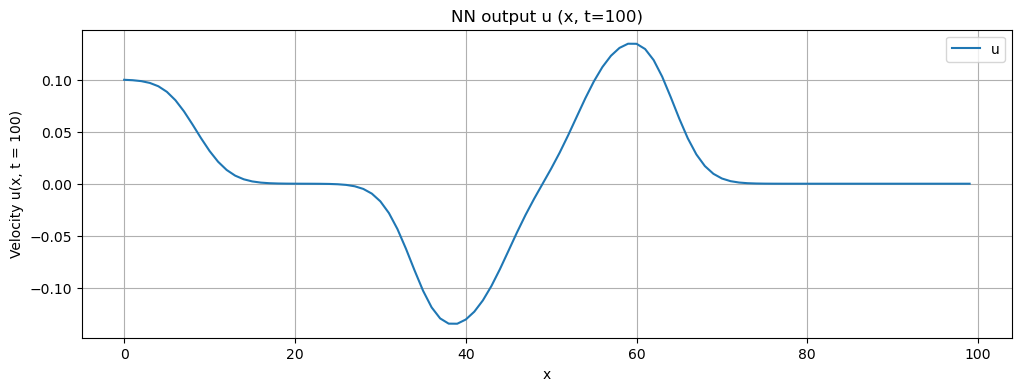

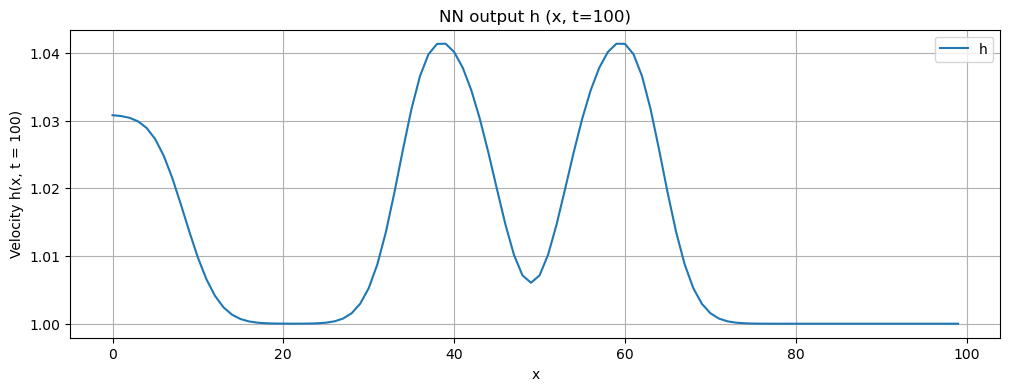

In [5]:
# An example of the input and output data for your neural network

Q_ex, g_ex, h_anom_ex = sample_parameters()

print('inputs q,g,h: ', Q_ex, g_ex, h_anom_ex) 

h,u = simulate_shallow_water(Q_ex[0], g_ex[0], h_anom_ex[0]) 
plt.figure(figsize=(12, 4))

plt.plot(u, label="u")
plt.xlabel("x")
plt.ylabel("Velocity u(x, t = 100)")
plt.title("NN output u (x, t=100)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(h, label="h")
plt.xlabel("x")
plt.ylabel("Velocity h(x, t = 100)")
plt.title("NN output h (x, t=100)")
plt.legend()
plt.grid(True)
plt.show()

# Design your neural network and training strategy
# Questions
1. Design your own neural network and loss function for the surrogate model
2. Evaluate the performance within and outside the parameter range of the training data. What do you observe?

In [ ]:
# We set the input as q,g,h and output as the concatenation of u(x,t=100) and h(x,t=100)

#TODO #define the input and output dimension
input_dim = 
output_dim = 2 * 

#TODO define your MLP neural network

class ParamToStateNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
        'create your neural network'
        )

    def forward(self, x):
        return self.net(x)


model_nn = ParamToStateNet().to(device)
optimizer = optim.Adam(model_nn.parameters(), lr=1e-3)
loss_fn = nn.MSELoss() # a mse loss calculated using the model output and groundtruth


In [7]:
# We normalize the input data so that all three inputs are in the same range to help backpropagation
# Precompute midpoints and half-ranges for normalization (both in numpy and pytorch)
Q_mid, Q_half = (Q_min + Q_max)/2.0, (Q_max - Q_min)/2.0
g_mid, g_half = (g_min + g_max)/2.0, (g_max - g_min)/2.0
h_mid, h_half = (h_min + h_max)/2.0, (h_max - h_min)/2.0

def normalize_params(Q, g, h_anom):
    """
    Map (Q, g, h_anom) to approximately [-1, 1] using the known ranges.
    """
    Qn = (Q - Q_mid) / Q_half
    gn = (g - g_mid) / g_half
    hn = (h_anom - h_mid) / h_half
    return np.stack([Qn, gn, hn], axis=-1).astype(np.float32)

def normalize_params_torch(Q, g, h_anom):
    """
    Map (Q, g, h_anom) to approximately [-1, 1] using the known ranges.
    """
    Qn = (Q - Q_mid) / Q_half
    gn = (g - g_mid) / g_half
    hn = (h_anom - h_mid) / h_half
    return torch.stack([Qn, gn, hn], dim=-1)

In [ ]:
num_epoch = 10000 #how many iterations of minimization  
batch_size = 32 #number of data samples (input-output pairs to be considered in one minization step)   
training_loss = []

for epoch in range(0, num_epoch):
    # Sample parameters
    Q_batch, g_batch, h_batch = sample_parameters(batch_size=batch_size)

    # run simulations and build targets 
    inputs = []
    targets = []
    for Q_i, g_i, h_i in zip(Q_batch, g_batch, h_batch):
        h_final, u_final = simulate_shallow_water(Q_i, g_i, h_i)
        
        target = np.concatenate([h_final, u_final])  # shape (2*Nx,)

        x_i = normalize_params(Q_i, g_i, h_i)        # shape (3,)
        
        inputs.append(x_i)
        targets.append(target.astype(np.float32))

    inputs = torch.tensor(np.stack(inputs, axis=0), device=device)    # (B, 3)
    targets = torch.tensor(np.stack(targets, axis=0), device=device)  # (B, 2*Nx)


    optimizer.zero_grad()
    
    #TODO compute the model prediction and the training loss
    preds = 
    loss = 
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"epoch {epoch}/{num_epoch}, loss = {loss.item():.4e}")


epoch 0/10000, loss = 5.3343e-01
epoch 100/10000, loss = 2.5072e-03
epoch 200/10000, loss = 3.0660e-04
epoch 300/10000, loss = 1.5849e-04
epoch 400/10000, loss = 1.0897e-04
epoch 500/10000, loss = 9.6140e-05
epoch 600/10000, loss = 7.1739e-05
epoch 700/10000, loss = 6.6042e-05
epoch 800/10000, loss = 4.6649e-05
epoch 900/10000, loss = 5.7349e-05
epoch 1000/10000, loss = 4.9858e-05
epoch 1100/10000, loss = 3.7548e-05
epoch 1200/10000, loss = 3.6910e-05
epoch 1300/10000, loss = 3.0311e-05
epoch 1400/10000, loss = 2.7300e-05
epoch 1500/10000, loss = 2.6282e-05
epoch 1600/10000, loss = 2.8311e-05
epoch 1700/10000, loss = 2.3800e-05
epoch 1800/10000, loss = 2.1871e-05
epoch 1900/10000, loss = 1.9163e-05
epoch 2000/10000, loss = 1.8848e-05
epoch 2100/10000, loss = 1.6271e-05
epoch 2200/10000, loss = 1.3700e-05
epoch 2300/10000, loss = 1.2086e-05
epoch 2400/10000, loss = 1.3741e-05
epoch 2500/10000, loss = 1.1309e-05
epoch 2600/10000, loss = 1.5063e-05
epoch 2700/10000, loss = 1.2963e-05
epoc

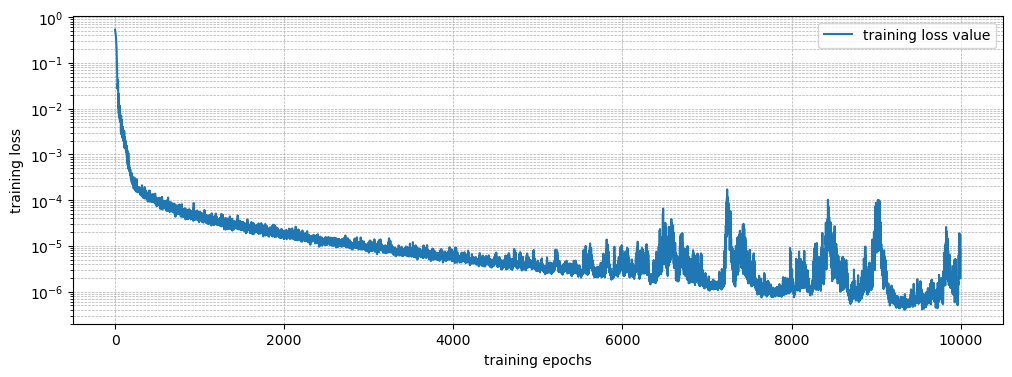

In [9]:
# plot the evolution of the loss function
plt.figure(figsize=(12, 4))
plt.plot(training_loss, label="training loss value")
plt.yscale("log")
plt.xlabel("training epochs")
plt.ylabel("training loss")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


# Evaluate the prediction performance on unseen parameters

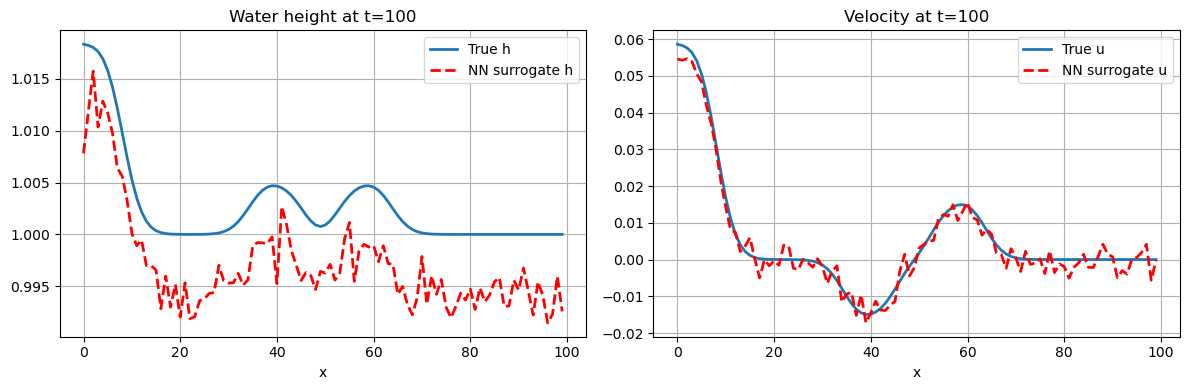

In [ ]:
#TODO change the reference parameters within and without the definition range of the training data, what can you observe?
# Reference parameters

Q_ref = 0.06 #these are by default test values
g_ref = 10.1
h_anom_ref = 1.01

# simulation output as ground truth
h_true, u_true = simulate_shallow_water(Q_ref, g_ref, h_anom_ref)

# NN prediction
x_ref = normalize_params(Q_ref, g_ref, h_anom_ref)[None, ...]   # shape (1, 3)

x_ref_t = torch.tensor(x_ref, device=device)

with torch.no_grad():
    y_pred = model_nn(x_ref_t).cpu().numpy()[0]  # (2*Nx,)

h_pred = y_pred[:Nx]
u_pred = y_pred[Nx:]


x_grid = np.arange(Nx) * dx

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_grid, h_true, label="True h", linewidth=2)
plt.plot(x_grid, h_pred, "--", label="NN surrogate h",  color='red',linewidth=2)
plt.xlabel("x")
#plt.ylabel("h(x, t=100)")
plt.title("Water height at t=100")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_grid, u_true, label="True u", linewidth=2)
plt.plot(x_grid, u_pred, "--", label="NN surrogate u", color='red',linewidth=2)
plt.xlabel("x")
#plt.ylabel("u(x, t=100)")
plt.title("Velocity at t=100")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Data assimilation for parameter identification
You will use the built surrogate model to identify the parameters from observed curves $u(x,t=100)$ and $h(x,t=100)$

The 3Dvar with NN transformation function will be performed using the TorchDA package

pip3 install git+https://github.com/acse-jm122/torchda.git

# Questions
1. Compute a 3D-Var for parameter calibration using the TorchDA package
2. Why some parameters are better corrected than the others? you can run some simulations to confirm your answer
3. Can you do an assimilation with partial observations (not fully observed h and v)

In [12]:
import torchda

We will perform a twin experiment: (i) fix some parameter values and run the simulation (ii) see if the DA system could identify those parameters 

In [13]:
# fix parameter values (the true value of parameters)
Q_true = 0.06
g_true = 10.2
h_anom_true = 1.01

# True simulation
h_true, u_true = simulate_shallow_water(Q_ref, g_ref, h_anom_ref)

y_true = np.concatenate((h_true,u_true),axis=0)

y = torch.from_numpy(y_true).float().to(device)


# prior (background) parameters: this is our initial guess
Q_prior = 0.08
g_prior = 9.7
h_anom_prior = 1.05

xb = torch.tensor([Q_prior, g_prior, h_anom_prior]).to(device).requires_grad_(True)



In [ ]:
import torchda

# set covariance matrices
B = torch.eye(3, device=device)
R = 0.01*torch.eye(200, device=device)

#TODO define the transformation function H using the trained NN model
def H(x: torch.Tensor):
    
    y_pred = 
        
    return y_pred


#TODO set the background state and the observation

results_3dvar = torchda.CaseBuilder().set_background_covariance_matrix(
    B
).set_observation_covariance_matrix(R).set_observations(
    'what is your observation?'
).set_background_state(
    'what is your background state?'
).set_algorithm(
    torchda.Algorithms.Var3D
).set_device(
    torchda.Device.GPU
).set_optimizer_args(
    {"lr": 1e-3}
).set_max_iterations(
    500
).set_observation_model(
    H
).execute()


Iterations: 0, J: 6.489883899688721, Norm of J gradient: 313.5564880371094
Iterations: 1, J: 9121789.0, Norm of J gradient: 1322090.25
Iterations: 2, J: 551086.6875, Norm of J gradient: 325048.28125
Iterations: 3, J: 2216196.75, Norm of J gradient: 747373.5625
Iterations: 4, J: 5095792.5, Norm of J gradient: 1133272.625
Iterations: 5, J: 2828439.5, Norm of J gradient: 831220.1875
Iterations: 6, J: 392836.21875, Norm of J gradient: 256233.875
Iterations: 7, J: 363253.34375, Norm of J gradient: 168010.765625
Iterations: 8, J: 1500984.875, Norm of J gradient: 479536.21875
Iterations: 9, J: 2410858.25, Norm of J gradient: 635400.1875
Iterations: 10, J: 2118000.5, Norm of J gradient: 601353.125
Iterations: 11, J: 1108324.875, Norm of J gradient: 403915.90625
Iterations: 12, J: 487052.65625, Norm of J gradient: 177379.65625
Iterations: 13, J: 380714.53125, Norm of J gradient: 122191.4765625
Iterations: 14, J: 773802.0625, Norm of J gradient: 349617.25
Iterations: 15, J: 1170150.875, Norm of 

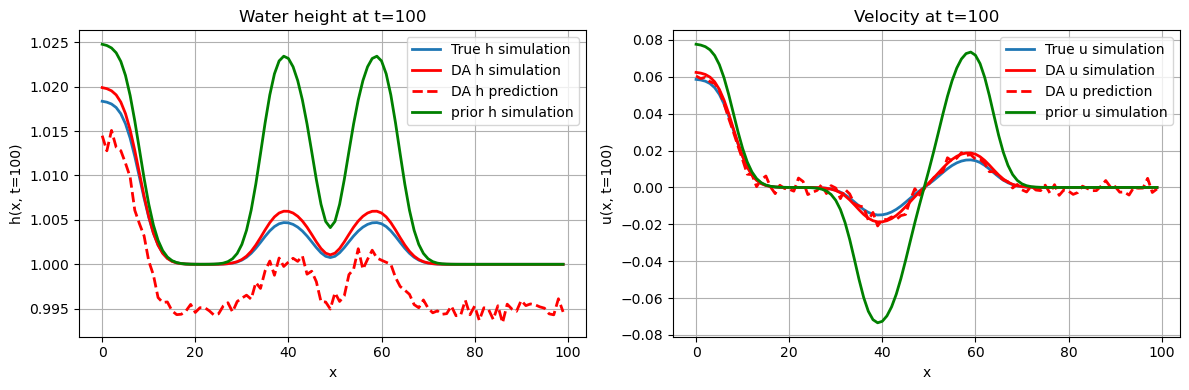

In [16]:
# Assimilated parameters
Q_ass = results_3dvar['assimilated_state'].detach().cpu().numpy()[0]
g_ass = results_3dvar['assimilated_state'].detach().cpu().numpy()[1]
h_anom_ass = results_3dvar['assimilated_state'].detach().cpu().numpy()[2]


# assimilated simulation
h_ass, u_ass = simulate_shallow_water(Q_ass, g_ass, h_anom_ass)


# background simulation
h_prior, u_prior = simulate_shallow_water(Q_prior, g_prior, h_anom_prior)

# NN prediction with assimilated parameters
x_ref = normalize_params(Q_ass, g_ass, h_anom_ass)[None, ...]   # shape (1, 3)
x_ref_t = torch.tensor(x_ref, device=device)
with torch.no_grad():
    y_pred = model_nn(x_ref_t).cpu().numpy()[0]  # (2*Nx,)
h_pred = y_pred[:Nx]
u_pred = y_pred[Nx:]

x_grid = np.arange(Nx) 

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_grid, h_true, label="True h simulation", linewidth=2)
plt.plot(x_grid, h_ass, label="DA h simulation",  color='red',linewidth=2)
plt.plot(x_grid, h_pred, '--', label="DA h prediction",  color='red',linewidth=2)
plt.plot(x_grid, h_prior, label="prior h simulation",  color='green',linewidth=2)
plt.xlabel("x")
plt.ylabel("h(x, t=100)")
plt.title("Water height at t=100")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_grid, u_true, label="True u simulation", linewidth=2)
plt.plot(x_grid, u_ass, label="DA u simulation", color='red',linewidth=2)
plt.plot(x_grid, u_pred, '--', label="DA u prediction",  color='red',linewidth=2)
plt.plot(x_grid, u_prior, label="prior u simulation",  color='green',linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x, t=100)")
plt.title("Velocity at t=100")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
print('True parameters of Q, g, h: ', Q_true, g_true, h_anom_true)

print('Assimilated parameters of Q, g, h: ', Q_ass, g_ass, h_anom_ass)


True parameters of Q, g, h:  0.06 10.2 1.01
Assimilated parameters of Q, g, h:  0.06400315 9.739309 1.012722
